In [9]:
# IMPORTS
import pandas as pd
import numpy as np
from datetime import datetime 
import yfinance as yf 
import matplotlib.pyplot as plt
import os

from metrics import evaluation_df

In [10]:
# Function to download historical stock data and save it as a CSV file
def download_csv_data(ticker, download_path='./data/'):
    data = yf.download(ticker, start=datetime(1900, 1, 1), end=datetime(2030, 1, 1)) 
    if not data.empty:
        data.to_csv(f'{download_path}{ticker}.csv')

def update_all(download_path='./data/'):
    for ticker in os.listdir(download_path):
        download_csv_data(ticker.replace('.csv', ''))

ticker = 'META'
#download_csv_data(ticker)
#update_all()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
# Function to read CSV files from the specified folder path and extract 'Adj Close' prices
def read_csv_close(folder_path = './data/'):
    df_close = pd.DataFrame()
    for file in os.listdir(folder_path):
        df_read = pd.read_csv(f'{folder_path}{file}', index_col=0)
        df_ticker = df_read['Adj Close']
        df_ticker.name = file.replace('.csv', '')
        df_close = pd.concat([df_close,df_ticker] , axis=1)
    df_close.index = pd.to_datetime(df_close.index)
    return df_close

read_csv_close()

,AAPL,AMZN,MA,META,MSFT,NVDA,SPOT,SPY,TSLA,V
1980-12-12,0.099058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,0.093890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-16,0.086999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-17,0.089152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.091737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2024-05-13,186.279999,186.570007,457.760010,468.010010,412.975098,903.989990,289.709991,520.909973,171.889999,278.873901
2024-05-14,187.429993,187.070007,454.200012,471.850006,415.809998,913.559998,290.119995,523.299988,177.550003,277.226929
2024-05-15,189.720001,185.990005,458.000000,481.540009,423.079987,946.299988,303.040009,529.780029,173.990005,280.979980
2024-05-16,189.839996,183.630005,458.869995,473.230011,420.989990,943.590027,298.119995,528.690002,174.839996,279.839996


In [12]:
def genetic_algorithm(fitness_function, num_generations=100, num_individuals=20, individual_size=4, elitism_rate=0.1, mutation_rate=0.3):
    """
    Executes a genetic algorithm.

    Parameters:
    - num_individuals: Number of individuals in the population.
    - individual_size: Size of each individual.
    - elitism_rate: Proportion of the top performers to carry over to the next generation.
    - mutation_rate: Rate at which mutations occur.
    - num_generations: Number of generations to evolve through.
    - fitness_function: Function used to evaluate the fitness of an individual.
    """
    
    # Function to create a population of individuals
    def create_population(individuals, individual_size):
        return np.random.uniform(size=(individuals, individual_size))

    # Function to select parents based on fitness
    def select(population, fitnesses, num_parents):
        idx = np.argsort(fitnesses)[::-1]
        return population[idx[:num_parents]], fitnesses[idx[:num_parents]]

    # Function to perform crossover among selected parents to produce offspring
    def crossover(parents, parents_fitnesses, num_offspring, individual_size):
        offspring = np.copy(parents)
        softmax_fitness = np.exp(parents_fitnesses)
        parents_probabilities = softmax_fitness / np.sum(softmax_fitness)    
        for i in range(num_offspring):
            random_parent_index = np.random.choice(np.arange(num_offspring), size=1, p=parents_probabilities)[0]
            random_genes_index = np.random.choice(np.arange(individual_size), size=int(individual_size/2), replace=False)
            offspring[i][random_genes_index] = parents[random_parent_index][random_genes_index]
        return offspring

    # Function to mutate offspring
    def mutate_offspring(offspring, num_offspring, individual_size):
        for i in range(num_offspring):
            random_genes_index = np.random.choice(np.arange(individual_size), size=np.random.randint(0, int(individual_size/2)+1), replace=False)
            offspring[i][random_genes_index] = np.random.uniform(0.0, 1.0, len(random_genes_index))
        return offspring

    # Function to normalize the population's gene values
    def normalize_population(population):
        return population / np.sum(population, axis=1, keepdims=True)

    # Calculate the number of individuals for elitism and mutation based on rates
    num_elites = int(elitism_rate*num_individuals)
    num_mutates = int(mutation_rate*num_individuals)
    num_parents = num_individuals - num_elites - num_mutates

    # Initialize the population
    population = create_population(num_individuals, individual_size)
    population = normalize_population(population)

    # Main loop for genetic algorithm
    for gen in range(num_generations):
        fitnesses = np.array([fitness_function(ind) for ind in population])
        parents, parents_fitnesses = select(population, fitnesses, num_parents)
        offspring = crossover(parents, parents_fitnesses, num_offspring=num_parents, individual_size=individual_size)
        offspring = mutate_offspring(offspring, num_offspring=num_parents, individual_size=individual_size)
        population[:num_elites, :] = parents[:num_elites]
        population[num_elites:num_elites+num_parents, :] = offspring
        population[num_elites+num_parents:, :] = create_population(num_mutates, individual_size)
        population = normalize_population(population)
        #print(f"({gen+1} / {num_generations}) Fitness Value: {parents_fitnesses[0]}", end="\r")

    # Print best solution after all generations
    best_individual = parents[0, :]
    best_fitness = parents_fitnesses[0]
    #print("Best solution :", best_individual)
    #print("Best solution fitness :", best_fitness)
    fitness_function(best_individual)
    return best_individual

# Example usage:
# genetic_algorithm(fitness_function, num_generations=100, num_individuals=20, individual_size=4, elitism_rate=0.1, mutation_rate=0.3)


In [13]:
import numpy as np
import matplotlib.pyplot as plt

def optimize_portfolio(method, df_close, allocation_date, historical_date, plot=True):
    # Calculate historical returns and prepare data
    tickers = list(df_close.columns)
    hist_returns = df_close.pct_change().dropna()
    hist_data = hist_returns[historical_date:allocation_date]
    correct_allocation_date = hist_data.index[-1]
    exp_returns = hist_data.iloc[:-1].mean()
    cov_matrix = hist_data.iloc[:-1].cov()

    # Lists to hold plot data
    exp_ret_plot, std_plot = [], []

    # Consolidate portfolio performance calculation
    def calculate_portfolio_performance(weights, add_to_plot=False):
        portfolio_return = np.dot(weights, exp_returns)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        if add_to_plot:
            exp_ret_plot.append(portfolio_return)
            std_plot.append(portfolio_std)
        return portfolio_return, portfolio_std

    # Objective functions
    def min_std(weights):
        _, portfolio_std = calculate_portfolio_performance(weights, True)
        return -portfolio_std

    def max_sharpe(weights):
        portfolio_return, portfolio_std = calculate_portfolio_performance(weights, True)
        return portfolio_return / portfolio_std

    # Optimize portfolio
    if method == "min_std":
        optimal_allocation = genetic_algorithm(fitness_function=min_std, num_generations=100, num_individuals=200, individual_size=len(tickers), elitism_rate=0.1, mutation_rate=0.3)
    elif method == "max_sharpe":
        optimal_allocation = genetic_algorithm(fitness_function=max_sharpe, num_generations=100, num_individuals=200, individual_size=len(tickers), elitism_rate=0.1, mutation_rate=0.3)
    #optimal_allocation = np.array([1.0, 0.0, 0.0])

    if plot:
        # Plotting
        plot_results(std_plot, exp_ret_plot, std_plot[-1], exp_ret_plot[-1])
    allocation_df = pd.DataFrame([np.round(optimal_allocation*100,2)], index=[correct_allocation_date], columns=tickers)
    return allocation_df
    

def plot_results(std_plot, exp_ret_plot, std_optimal, exp_optimal):
    plt.figure(figsize=(7, 4))
    plt.scatter(std_plot, exp_ret_plot, color='blue', alpha=0.1, s=5)
    plt.scatter(std_optimal, exp_optimal, color='red', label='Optimal Portfolio', s=50)
    plt.xlabel('Standard Deviation')
    plt.ylabel('Expected Returns')
    plt.title('Standard Deviation vs Expected Returns of Portfolio')
    plt.legend()
    plt.show()

In [14]:

def plot_portfolio(portfolio_roi, stock_roi):
    # Plotting the ROI
    plt.figure(figsize=(12, 4))
    plt.plot(portfolio_roi.index, portfolio_roi, label='Portfolio', linewidth=2, color='black')
    for stock in stock_roi.columns:
        plt.plot(stock_roi.index, stock_roi[stock], label=stock, linestyle='--')
    plt.title('ROI Over Time')
    plt.xlabel('Date')
    plt.ylabel('ROI (%)')
    plt.legend()
    plt.show()
    
def evaluate_portfolio(df_close, portfolio_value):
    df_eval = df_close.loc[portfolio_value.index[0]:portfolio_value.index[-1]].copy()
    df_eval['Portfolio ROI%'] = 100 * ((1 + portfolio_value.pct_change()).cumprod() - 1).fillna(0)
    list_name = ['Portfolio']
    list_results = [df_eval['Portfolio ROI%'].to_frame()]
    for ticker in df_close.columns:
        roi = 100 * ((1 + df_eval[ticker].pct_change()).cumprod() - 1).fillna(0)
        list_name.append(ticker)
        list_results.append(roi.to_frame())
    eval_df = evaluation_df(list_name, list_results)
    print(eval_df.to_string())

def plot_eval_portfolio_allocation(df_close, allocation_df, end_date, initial_capital=1000):
    prices = df_close[allocation_df.index[0]:end_date].copy()
    capital = initial_capital
    portfolio_value = pd.DataFrame()
    for i, allocation_date in enumerate(allocation_df.index):
        if allocation_date >= prices.index[-1]:
            break
        current_prices = prices.loc[allocation_date]
        stock_quantities = (allocation_df.iloc[i]/100 * capital) / current_prices
        if i+1 < len(allocation_df.index):
            next_allocation_date = allocation_df.index[i+1]
        else:
            next_allocation_date = prices.index[-1]
        portfolio_capital = (stock_quantities * prices[allocation_date:next_allocation_date]).sum(axis=1).iloc[:-1]
        capital = portfolio_capital.iloc[-1]
        portfolio_value = pd.concat([portfolio_value, portfolio_capital])

    # Calculate the ROI
    portfolio_roi = (portfolio_value / initial_capital - 1) * 100
    stock_roi = ((prices / prices.iloc[0]) - 1) * 100
    
    plot_portfolio(portfolio_roi, stock_roi)
    evaluate_portfolio(df_close, portfolio_value)

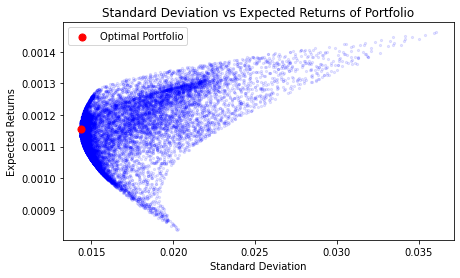

,AAPL,V,TSLA
2011-10-06,73.26,24.69,2.06


In [15]:
# Get Close price data
df_close = read_csv_close()

# Select tickers
tickers_list = ["AAPL", "V", "MSFT", "TSLA", "AMZN", "MA", "NVDA", "SPY"]
tickers_list = ["AAPL", "V", "TSLA"]

# Select Dates
historical_date = '2010-10-03'
allocation_date = '2011-10-06'
method="min_std"
optimize_portfolio(method, df_close[tickers_list].dropna().copy(), allocation_date, historical_date)

Backtesting from: 2023-01-01 to 2024-01-01
ALLOCATING CAPITAL: 2023-01-01 00:00:00
ALLOCATING CAPITAL: 2023-02-01 00:00:00
ALLOCATING CAPITAL: 2023-03-01 00:00:00
ALLOCATING CAPITAL: 2023-04-01 00:00:00
ALLOCATING CAPITAL: 2023-05-01 00:00:00
ALLOCATING CAPITAL: 2023-06-01 00:00:00
ALLOCATING CAPITAL: 2023-07-01 00:00:00
ALLOCATING CAPITAL: 2023-08-01 00:00:00
ALLOCATING CAPITAL: 2023-09-01 00:00:00
ALLOCATING CAPITAL: 2023-10-01 00:00:00
ALLOCATING CAPITAL: 2023-11-01 00:00:00
ALLOCATING CAPITAL: 2023-12-01 00:00:00
ALLOCATING CAPITAL: 2024-01-01 00:00:00
ALLOCATING CAPITAL: 2024-02-01 00:00:00
             AAPL   AMZN   MSFT   NVDA   META   SPOT
2022-12-30   0.02   0.27   0.67   0.05  98.46   0.53
2023-02-01  10.75   6.98   0.01  11.59  38.72  31.96
2023-03-01   1.11   0.01   0.01  67.51  30.98   0.38
2023-03-31  15.64   0.01  45.66  14.44   3.83  20.42
2023-05-01   0.31   0.01  36.93   0.04  40.72  21.99
2023-06-01   0.23  42.84   0.05   9.98  26.86  20.05
2023-06-30  94.81   0.24  

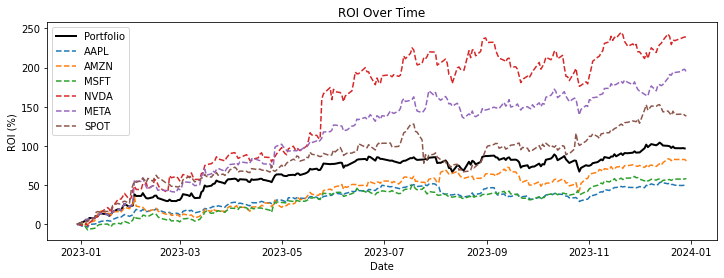

                       Portfolio   AAPL   AMZN   MSFT    NVDA    META    SPOT
RoI %                      96.70  49.82  82.60  57.87  239.02  197.76  139.08
MaxDrawDown %             -11.59 -14.93 -19.64 -12.99  -18.29  -12.97  -26.84
Expected RoI %              0.29   0.17   0.26   0.20    0.54    0.47    0.38
Downside Volatility %       0.85   0.71   1.13   0.83    1.28    0.95    1.38
Sortino Ratio               5.37   3.80   3.70   3.75    6.65    7.81    4.38
Volatility %                1.80   1.28   2.08   1.58    3.06    2.51    2.47
Sharpe Ratio                2.54   2.12   2.01   1.97    2.78    2.96    2.45


In [16]:
from dateutil.relativedelta import relativedelta
from datetime import datetime


lookback_period = 1
step_period = 1
strategy_start_date = '2023-01-01'
strategy_end_date = '2024-01-01'
method="max_sharpe"
show = False
tickers_list = ["AAPL", "AMZN", "MSFT", "NVDA", "META", "SPOT"]
df_close = read_csv_close()[tickers_list].dropna()
#df_close['USD'] = 1.0

print(f'Backtesting from: {strategy_start_date} to {strategy_end_date}')

step = 0
allocation_df = pd.DataFrame()
while True:
    allocation_date = datetime.strptime(strategy_start_date, "%Y-%m-%d") + relativedelta(months=step)
    print("ALLOCATING CAPITAL:", allocation_date)
    historical_date = allocation_date - relativedelta(months=lookback_period)
    allocation_df = pd.concat([allocation_df, optimize_portfolio(method, df_close.copy(), allocation_date, historical_date, show)])
    if allocation_date > datetime.strptime(strategy_end_date, "%Y-%m-%d"):
        break
    step += step_period
print(allocation_df.to_string())
plot_eval_portfolio_allocation(df_close.copy(), allocation_df, strategy_end_date)
